## FLAML for hp optimisation and model selection
We use FLAML twice, first to find the best component model for each estimator, and then to optimise the estimators themselves and choose the best estimator. Here we show how it's done

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now.. 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# the below checks for whether we run dowhy and auto-causality from source
root_path = root_path = os.path.realpath('../..')
try: 
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))
    
try:
    import dowhy
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "dowhy"))

In [2]:
# this makes the notebook expand to full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%%javascript

// turn off scrollable windows for large output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from auto_causality import AutoCausality
from auto_causality.datasets import synth_ihdp
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import ate, group_ate

### Model fitting & scoring
Here we fit a (selection of) model(s) to the data and score them with the ERUPT metric on held-out data

In [28]:
from causaldata import thornton_hiv

thl = thornton_hiv.load_pandas()
df_thl = thl.data
df_thl = df_thl.dropna()
df_thl.head()

,villnum,got,distvct,tinc,any,age,hiv2004
0,1.0,1.0,2.718921,2.08032,1.0,22.0,0.0
2,1.0,1.0,2.485713,1.89120,1.0,19.0,0.0
4,1.0,1.0,1.837131,0.09456,1.0,53.0,0.0
5,1.0,1.0,2.217743,0.94560,1.0,50.0,0.0
10,1.0,0.0,2.907790,0.56736,1.0,21.0,0.0


In [30]:
treatment = 'tinc'
targets='got'
data_df, features_X, features_W = preprocess_dataset(df_thl, treatment, targets)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)

In [3]:
# import dataset and pre-process it 
# that one-hot-encodes all categorical and int variables
# because otherwise DoWhy/EconML will do it for us in hard-to-reproduce ways
# if you don't want an int variable to be one-hot-encoded, 
# please cast it to float before preprocessing

data_df = synth_ihdp()
treatment = 'treatment'
targets=['y_factual']
data_df, features_X, features_W = preprocess_dataset(data_df, treatment, targets)
outcome = targets[0]

train_df, test_df = train_test_split(data_df, test_size=0.2)

In [7]:
data_df_A == data_df

,treatment,y_factual,x1,x2,x3,x4,x5,x6,x7,x8,...,x17,x18,x19,x20,x21,x22,x23,x24,x25,random
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
743,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
744,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
745,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [ ]:

# If you want to use specific estimators, comment in the estimator_list below
# to include any estimators whose full name contains any of the elements of 
# estimator_list
# The other allowed values are 'all' and 'auto', the default is 'auto'
ac = AutoCausality(
    time_budget=120, 
    estimator_list=[
            # "Dummy",
            "SparseLinearDML",
            "ForestDRLearner",
            "TransformedOutcome",
            "CausalForestDML",
            ".LinearDML",
            "DomainAdaptationLearner",
            "SLearner",
            # "XLearner",
            # "TLearner",
            # "Ortho",
        ],
    # metric="norm_erupt", 
    verbose=1, # 3
    components_verbose=1,# 2
    components_time_budget=10,
)


# run autocausality
ac.fit(train_df, treatment, outcome, features_W, features_X)

# return best estimator
print(f"Best estimator: {ac.best_estimator}")
# config of best estimator:
print(f"best config: {ac.best_config}")
# best score:
print(f"best score: {ac.best_score}")


In [34]:
# return best estimator
print(f"Best estimator: {ac.best_estimator}")
# config of best estimator:
print(f"best config: {ac.best_config}")
# best score:
print(f"best score: {ac.best_score}")

Could not find best trial. Did you pass the correct `metric` parameter?


AttributeError: 'NoneType' object has no attribute 'last_result'

In [ ]:
# we can now resume the fit to continue with the init_cfgs which we haven't tried yet
# ac.fit(train_df, treatment, outcome, features_W, features_X,resume=True)
# # return best estimator
# print(f"Best estimator: {ac.best_estimator}")
# # config of best estimator:
# print(f"best config: {ac.best_config}")
# # best score:
# print(f"best score: {ac.best_score}")

In [12]:
ac.results.results

{'93f35b88': {'norm_erupt': 2.5659110767877165,
  'estimator_name': 'backdoor.auto_causality.models.Dummy',
  'scores': {'train': {'erupt': 6.378194532495857,
    'norm_erupt': 2.27075982479105,
    'qini': -0.03539665056947157,
    'auc': 0.49071976418693675,
    'ate': 4.026648746798304,
    'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter at 0x7f9a99952240>,
    'values':      treated  y_factual         p  policy  norm_policy   weights
    0        0.0   2.923599  0.197065    True        False  0.000000
    1        0.0   1.755712  0.197065    True        False  0.000000
    2        0.0   1.149127  0.197065    True         True  0.000000
    3        0.0   0.400709  0.197065    True        False  0.000000
    4        0.0   2.172268  0.197065    True        False  0.000000
    ..       ...        ...       ...     ...          ...       ...
    472      0.0   1.470431  0.197065    True        False  0.000000
    473      0.0  -0.043730  0.197065    True    

In [13]:
# score all estimators on the test set, which we've kept aside up till now
from auto_causality.scoring import make_scores
for est_name, scr in ac.scores.items():
    scr['scores']['test'] = make_scores(scr['estimator'], test_df, ac.propensity_model)

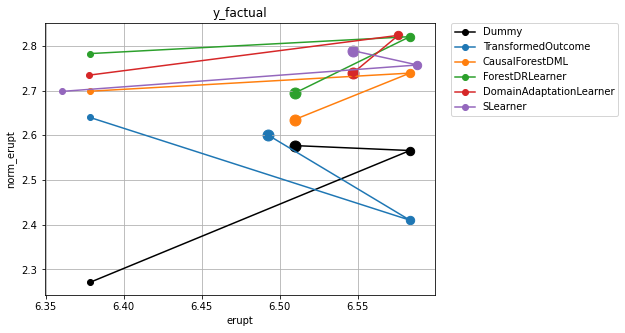

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])


plt.figure(figsize = (7,5))
plt.title(outcome)

m1 = "erupt"
m2 = "norm_erupt"

for (est, scr), col in zip(ac.scores.items(), colors):
    try:
        sc = [scr["scores"]['train'][m1], scr["scores"]['validation'][m1], scr["scores"]['test'][m1]]
        crv = [scr["scores"]['train'][m2], scr["scores"]['validation'][m2], scr["scores"]['test'][m2]]
        plt.plot(sc, crv, color=col, marker="o", label=est.split(".")[-1])
        plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_")
        plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_")
    except:
        pass
plt.xlabel(m1)
plt.ylabel(m2)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.grid()
plt.show()


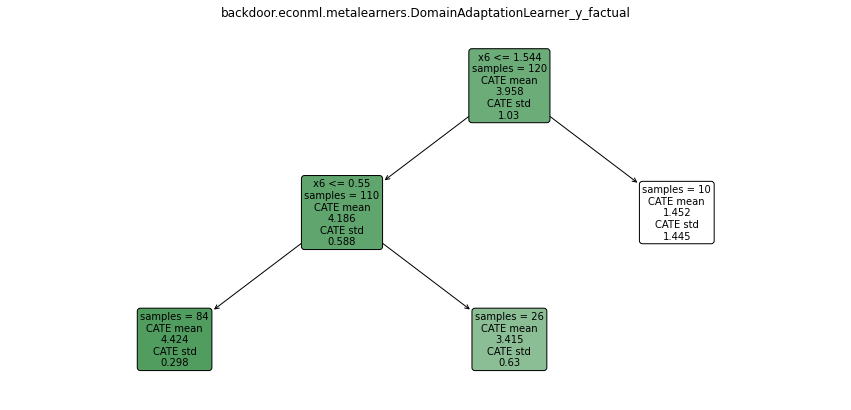

In [15]:
scr = ac.scores[ac.best_estimator]
intrp = scr["scores"]['validation']['intrp']
plt.figure(figsize=(15, 7))
intrp.plot(feature_names=intrp.feature_names, fontsize=10)
plt.title(f"{ac.best_estimator}_{outcome}")
plt.show()


y_factual backdoor.econml.metalearners.DomainAdaptationLearner


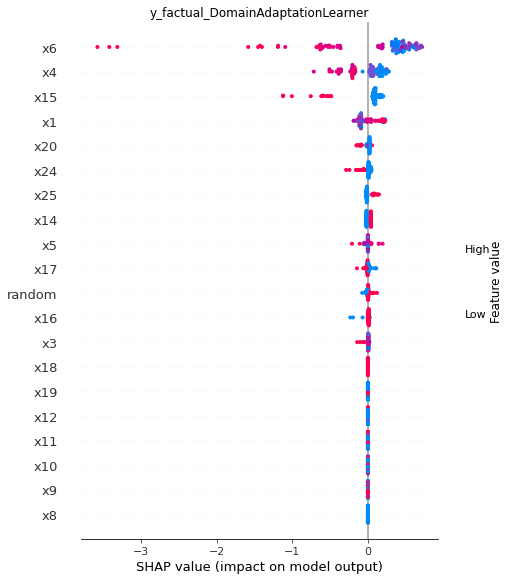

In [16]:
# TODO: add SHAP plots!
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = test_df.sample(100)

# ? Works only on specific models?
scr = ac.scores[ac.best_estimator]
print(outcome, ac.best_estimator)
est = ac.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ac.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
plt.show()


,policy,mean,std,count
0,all,3.989167,0.271275,150
1,True,4.310942,0.211124,99
2,False,3.822496,0.503548,51


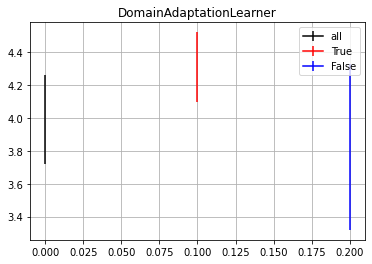

In [17]:
from auto_causality.scoring import  group_ate
# plot out-of sample difference of outcomes between treated and untreated for the points where a model predicts positive vs negative impact
my_est = ac.best_estimator
stats = []

v = ac.scores[my_est]['scores']['test']['values']

sts = group_ate(v['treated'], v[outcome], v['norm_policy'])

display(sts)


colors = (matplotlib.colors.CSS4_COLORS['black'],
    matplotlib.colors.CSS4_COLORS['red'],
    matplotlib.colors.CSS4_COLORS['blue'])

grp = sts["policy"].unique()

for i,(p,c) in enumerate(zip(grp, colors)):
    st = sts[sts["policy"] == p]
    plt.errorbar(np.array(range(len(st))) +0.1*i, st["mean"].values[0],  yerr = st["std"].values[0], color=c)
plt.legend(grp)
plt.grid(True)
plt.title(my_est.split('.')[-1])
plt.show()